# MRI maps

Goal: Correlate gradients with HCP maps from Jakob

In [2]:
# Import modules and R
import numpy as np, pandas as pd
from plotnine import *
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append('../code')
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
from gradientVersion import *
from pcaVersion import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.


In [136]:
dm_hcp_ds8 = gradientVersion().fit('hcp_ds8')
scores = dm_hcp_ds8.clean_scores()

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_ds8


In [131]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
scores = dm_hcp_3d_ds5.clean_scores()

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [137]:
maps = (pd.concat([
    pd.read_csv("../data/maturational/mat_index.csv", header=None, squeeze=True).rename('MI'),
    # pd.read_csv("../data/maturational/mat_index_pspin_fdr.csv", header=None, squeeze=True).rename('MI_sig')
], axis=1)
        .iloc[:180]
        .set_axis(get_labels_hcp()[:180])
       )

In [141]:
corrs = get_corrs(scores, maps)
sim_grads = np.load("../outputs/permutations/hcp_ds8_sim_1000.npy")
# sim_grads = np.load("../outputs/permutations/hcp_3d_ds5_sim_1000.npy")
null_corrs = corr_nulls_from_grads(sim_grads, scores, maps, method='pearson')
null_p = get_null_p(corrs, null_corrs, adjust='fdr_bh')

In [142]:
maps_to_scatter = ['MI']#, 'MI_sig']
maps_scatter = (maps
                .loc[:, maps_to_scatter]
                .melt(ignore_index=False, var_name='map', value_name='map_score')
                .join(scores.set_index('label')).reset_index()
                .set_index(['label','map','map_score'])
                .melt(ignore_index=False, var_name='G', value_name='G_score')
                .reset_index()
               )
maps_scatter_corrs = null_p.query("map in @maps_to_scatter").loc[:,['map','G','true_mean','q']]
maps_to_plot = maps.loc[:, maps_to_scatter]

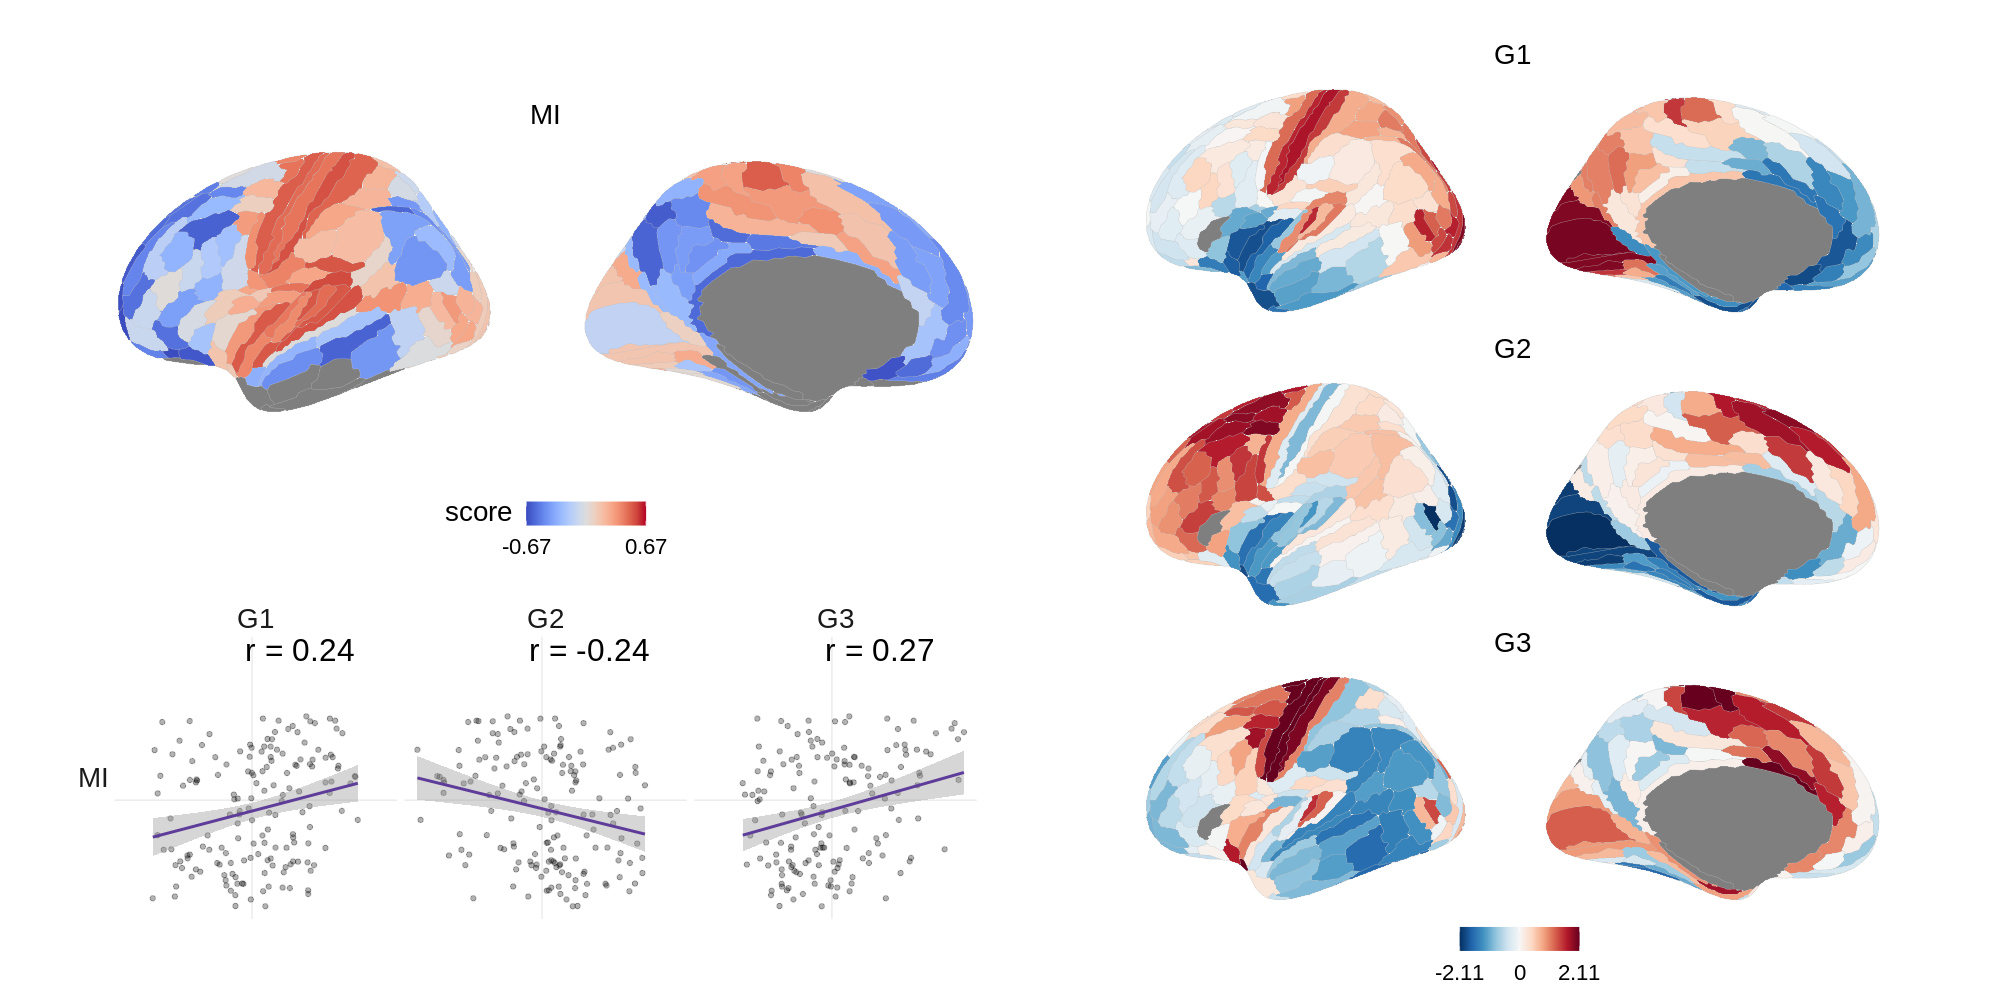

In [143]:
%%R -i scores -i maps_scatter -i maps_scatter_corrs -i maps_to_plot -i maps2 -w 20 -h 10 --units in -r 100
source("../code/plot_maps.R")

g1 <- plot_maps(maps_to_plot, ncol=1, colors=coolwarm(100), spacing=0) 
g2 <- plot_hcp(scores, facet='w')
g4 <- plot_maps_scatter(maps_scatter, maps_scatter_corrs, x=1, y=1)

(((g1 / g4) + plot_layout(heights=c(3,2))) | g2) & 
theme(strip.text=element_text(size=20), text=element_text(size=20))